<a href="https://colab.research.google.com/github/MattLScruggs/DataScienceRamblings/blob/main/covid_19_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting COVID-19 Cases

## Loading and cleaning data

In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
!pip install sodapy
!pip install nbconvert

In [3]:
import numpy as np
import pandas as pd
import sodapy
from sodapy import Socrata
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
client = Socrata("data.cdc.gov", None)
results = client.get("7dk4-g6vg", limit = 100000)

In [5]:
full_data=pd.DataFrame.from_records(results)
full_data.shape[0]

11318

In [6]:
print(full_data.dtypes)
full_data.columns

week_ending_date                   object
state                              object
avg_adm_all_covid_confirmed        object
pct_chg_avg_adm_all_covid          object
total_adm_all_covid_confirmed      object
total_adm_all_covid_confirmed_1    object
sum_adm_all_covid_confirmed        object
avg_total_patients                 object
avg_percent_inpatient_beds         object
abs_chg_avg_percent_inpatient      object
avg_percent_staff_icu_beds         object
abs_chg_avg_percent_staff          object
dtype: object


Index(['week_ending_date', 'state', 'avg_adm_all_covid_confirmed',
       'pct_chg_avg_adm_all_covid', 'total_adm_all_covid_confirmed',
       'total_adm_all_covid_confirmed_1', 'sum_adm_all_covid_confirmed',
       'avg_total_patients', 'avg_percent_inpatient_beds',
       'abs_chg_avg_percent_inpatient', 'avg_percent_staff_icu_beds',
       'abs_chg_avg_percent_staff'],
      dtype='object')

In [7]:
#renaming columns I'll be using
full_data=full_data.rename({
                 'state':'geo_location',
                 'avg_adm_all_covid_confirmed':'new_adm_7day_avg',
                 'total_adm_all_covid_confirmed':'new_adm_7day_total',
                 'total_adm_all_covid_confirmed_1':'new_adm_7day_total_per100k',
                 'avg_percent_inpatient_beds':'inpatient_bed_occ_7day_avg',
                 'avg_percent_staff_icu_beds':'icu_bed_occ_7day_avg'},axis=1)

In [8]:
#converting numerical variables to float64 instead of object
full_data=full_data.astype({
                 'new_adm_7day_avg':'float64',
                 'new_adm_7day_total':'float64',
                 'new_adm_7day_total_per100k':'float64',
                 'inpatient_bed_occ_7day_avg':'float64',
                 'icu_bed_occ_7day_avg':'float64'},errors = 'raise')[['week_ending_date','geo_location','new_adm_7day_total_per100k','inpatient_bed_occ_7day_avg','icu_bed_occ_7day_avg']]

In [9]:
full_data.head()

,week_ending_date,geo_location,new_adm_7day_total_per100k,inpatient_bed_occ_7day_avg,icu_bed_occ_7day_avg
0,2023-01-28T00:00:00.000,Region 5,7.618658,3.352234,2.831918
1,2023-02-04T00:00:00.000,Region 5,7.068622,2.979418,2.557692
2,2023-02-11T00:00:00.000,Region 5,7.323656,2.860270,2.310260
3,2023-02-18T00:00:00.000,Region 5,7.765207,3.033976,2.413452
4,2023-02-25T00:00:00.000,Region 5,7.599625,3.130219,2.511139


### Turning raw data into a useful timeseries
I'm going to just use the "new_adm" column, since that's the metric that I'm concerned with (total new admissions per 100k for the previous 7 day period). I'll turn the week_ending column into the index, pivot on that, and drop the rest.

In [10]:
full_data['week']=pd.to_datetime(full_data['week_ending_date'])
full_data=full_data.set_index(['week']).drop(columns=['week_ending_date','inpatient_bed_occ_7day_avg','icu_bed_occ_7day_avg'])
full_data.head()

,geo_location,new_adm_7day_total_per100k
week,,
2023-01-28,Region 5,7.618658
2023-02-04,Region 5,7.068622
2023-02-11,Region 5,7.323656
2023-02-18,Region 5,7.765207
2023-02-25,Region 5,7.599625


In [11]:
case_data=full_data.pivot(columns='geo_location',values = 'new_adm_7day_total_per100k')
case_data.head()

geo_location,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,TX,USA,UT,VA,VI,VT,WA,WI,WV,WY
week,,,,,,,,,,,,,,,,,,,,,
2020-08-08,3.827516,13.542218,14.878369,NaN,10.441401,11.849498,5.487315,2.832872,14.452730,0.718860,...,17.861158,9.524743,3.992566,3.936492,0.939805,0.480778,2.495111,8.810748,5.412502,12.094844
2020-08-15,3.007334,13.440243,13.652311,NaN,9.919331,10.358820,4.445420,1.430460,14.736117,3.080829,...,15.160774,8.996444,3.930182,4.944046,0.939805,0.801296,2.455714,8.295500,4.129126,6.911340
2020-08-22,4.237607,15.806053,14.083088,NaN,8.806497,8.374624,2.552643,2.159714,12.610716,4.826632,...,13.163939,8.862412,2.776081,4.862036,15.976693,0.961555,2.127410,7.608502,5.189306,6.392989
2020-08-29,4.237607,17.417250,11.332744,NaN,7.254026,7.324316,2.378994,1.738990,9.776847,5.956269,...,11.818920,8.491940,3.930182,4.639437,7.518444,0.961555,1.891031,7.333703,6.361085,6.392989
2020-09-05,4.784395,16.907378,10.868830,NaN,6.635785,6.744748,2.413724,2.187762,11.477168,6.777823,...,11.111923,7.970267,4.335678,5.447823,3.759222,0.801296,2.534507,6.784104,5.356703,7.256907


In [12]:
case_data.to_csv('/drive/MyDrive/Documents/case_data_112723.csv')

In [13]:
us_data=case_data['USA']

In [14]:
us_data.head()

week
2020-08-08    9.524743
2020-08-15    8.996444
2020-08-22    8.862412
2020-08-29    8.491940
2020-09-05    7.970267
Name: USA, dtype: float64

In [15]:
us_data.tail()

week
2023-10-14    4.829990
2023-10-21    4.770052
2023-10-28    4.852881
2023-11-04    4.502288
2023-11-11    4.891133
Name: USA, dtype: float64

#### Understanding our timeseries

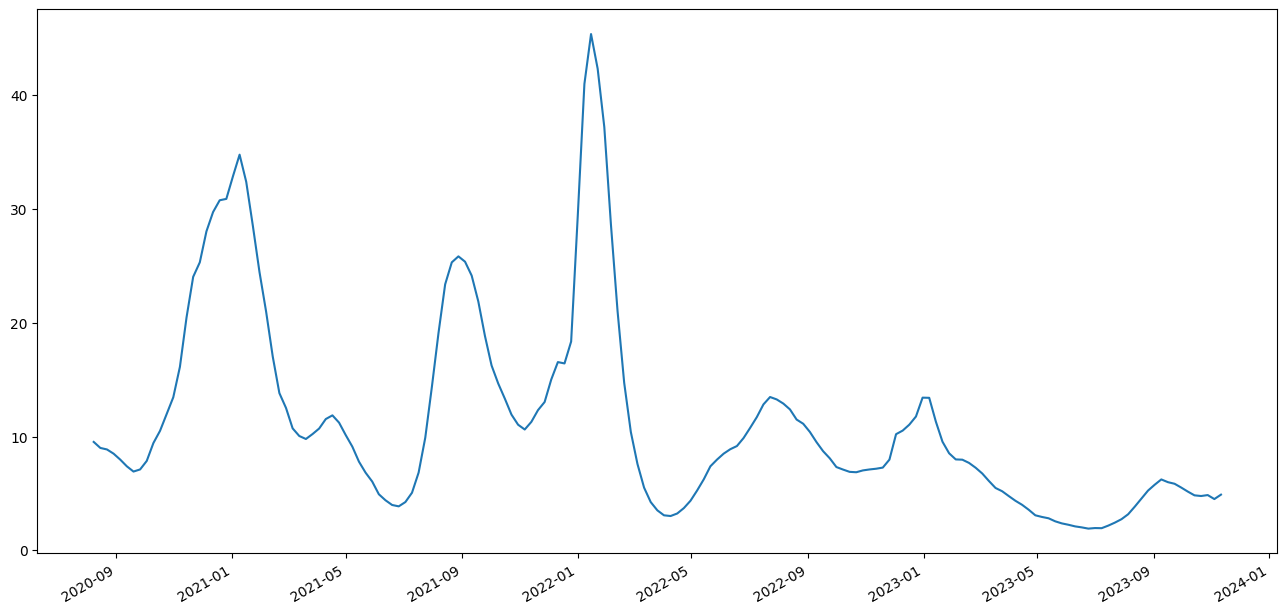

In [16]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(us_data)
fig.autofmt_xdate()

In [17]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

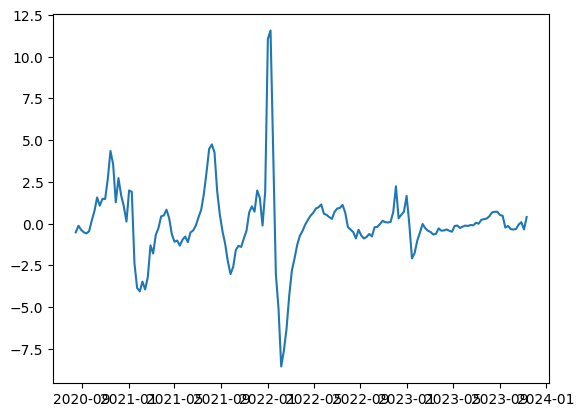

In [18]:
diff_data= us_data.diff()[1:]
plt.plot(diff_data)

In [19]:
ad_fuller_result = adfuller(us_data)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.548593836498051
p-value: 0.006823363143812838


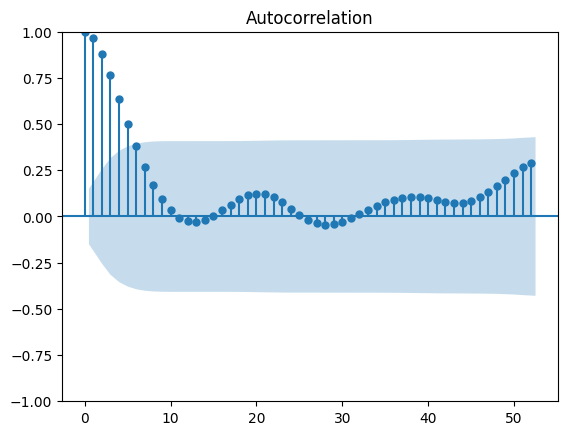

In [22]:
plot_acf(us_data, lags=52);

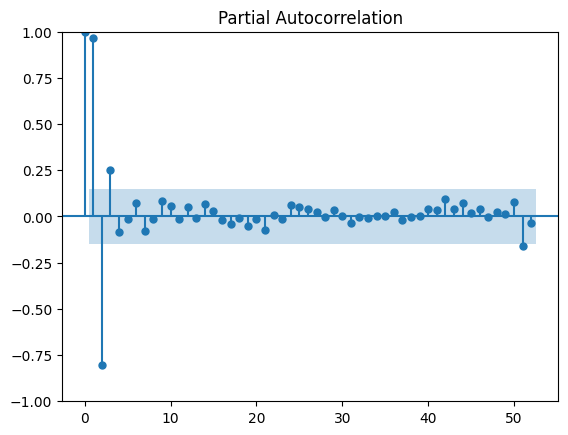

In [23]:
plot_pacf(us_data, lags = 52, method = 'ywm');

In [24]:
from statsmodels.tsa.seasonal import STL

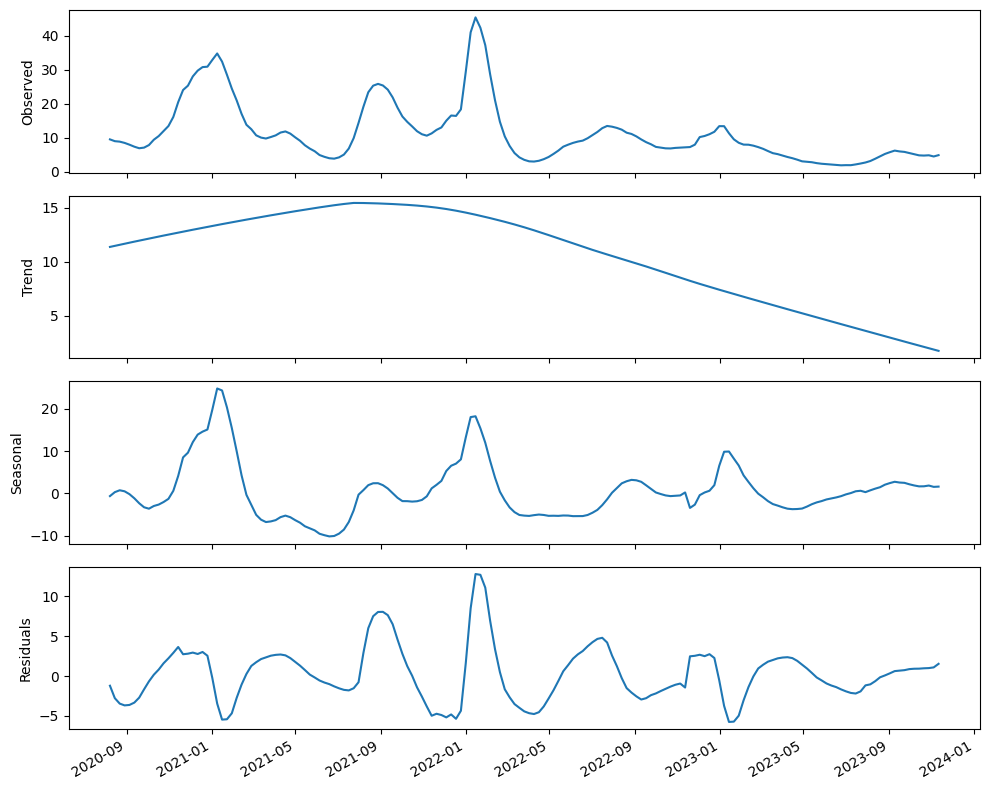

In [25]:
decomp = STL(us_data, period=52).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, ncols =1, sharex = True, figsize = (10,8))
ax1.plot(decomp.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomp.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomp.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomp.resid)
ax4.set_ylabel('Residuals')
fig.autofmt_xdate()
plt.tight_layout()

#### Format the data

In [26]:
us_data.tail(24)

week
2023-06-03    2.242711
2023-06-10    2.100546
2023-06-17    2.013199
2023-06-24    1.904768
2023-07-01    1.954164
2023-07-08    1.942418
2023-07-15    2.168315
2023-07-22    2.431862
2023-07-29    2.734264
2023-08-05    3.166782
2023-08-12    3.835138
2023-08-19    4.541143
2023-08-26    5.248654
2023-09-02    5.760989
2023-09-09    6.228145
2023-09-16    5.987188
2023-09-23    5.847132
2023-09-30    5.515514
2023-10-07    5.157994
2023-10-14    4.829990
2023-10-21    4.770052
2023-10-28    4.852881
2023-11-04    4.502288
2023-11-11    4.891133
Name: USA, dtype: float64

In [49]:
train_stop='2023-10-07'
test_start='2023-10-14'
test_stop='2023-11-11'

In [50]:
train=us_data[:train_stop]
test=us_data[test_start:test_stop]
print(train.head())
print(train.tail())
print(test.head())

week
2020-08-08    9.524743
2020-08-15    8.996444
2020-08-22    8.862412
2020-08-29    8.491940
2020-09-05    7.970267
Name: USA, dtype: float64
week
2023-09-09    6.228145
2023-09-16    5.987188
2023-09-23    5.847132
2023-09-30    5.515514
2023-10-07    5.157994
Name: USA, dtype: float64
week
2023-10-14    4.829990
2023-10-21    4.770052
2023-10-28    4.852881
2023-11-04    4.502288
2023-11-11    4.891133
Name: USA, dtype: float64


### Model building and forecast

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [52]:
my_order = (3,0,0)
my_seasonal_order = (2,0,0,26)

Format the training set so it doesn't throw errors

In [53]:
train=train.reset_index(drop=True)
train

0      9.524743
1      8.996444
2      8.862412
3      8.491940
4      7.970267
         ...   
161    6.228145
162    5.987188
163    5.847132
164    5.515514
165    5.157994
Name: USA, Length: 166, dtype: float64

In [54]:
model=SARIMAX(train, order= my_order, seasonal_order=my_seasonal_order, simple_differencing = False)
SARIMA_model=model.fit(disp=False)

In [55]:
print(SARIMA_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                USA   No. Observations:                  166
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 26)   Log Likelihood                -248.649
Date:                            Mon, 27 Nov 2023   AIC                            509.298
Time:                                    16:21:42   BIC                            527.969
Sample:                                         0   HQIC                           516.877
                                            - 166                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1974      0.057     38.577      0.000       2.086       2.309
ar.L2         -1.7001      0.109   

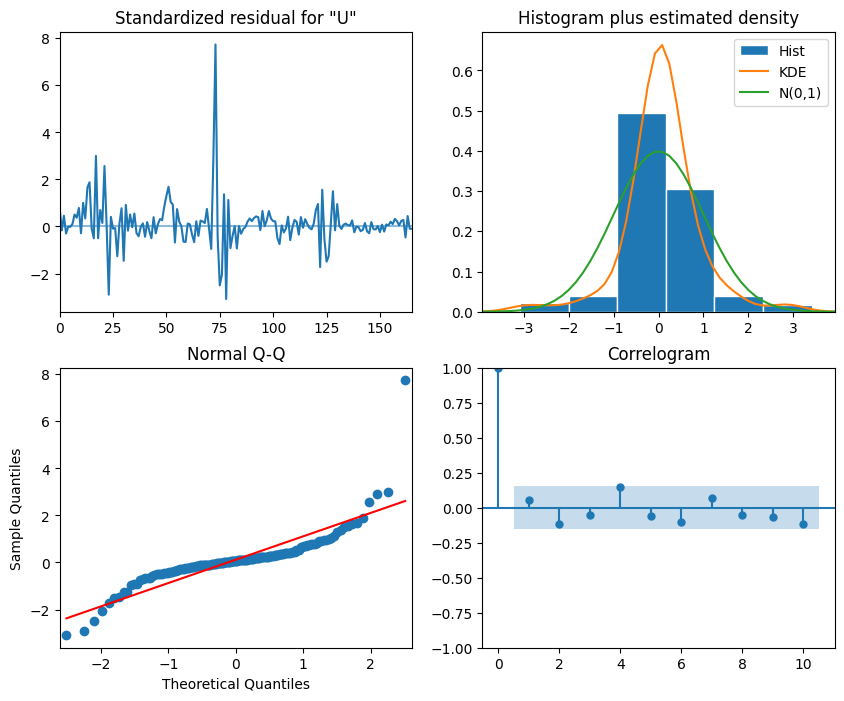

In [56]:
SARIMA_model.plot_diagnostics(figsize= (10,8));

#### Build rolling forecast function

In [57]:
def rolling_forecast(df: pd.DataFrame , train_len: int, horizon: int, window: int) -> list:

    total_len = train_len + horizon

    pred_model = []

    for i in range(train_len, total_len, window):
        model=SARIMAX(df[:i], order= my_order, seasonal_order=my_seasonal_order, simple_differencing = False)
        model_fit=model.fit(disp=False)
        predictions = model_fit.get_prediction(0,i + window - 1)
        oos_predictions=predictions.predicted_mean.iloc[-window:]
        pred_model.extend(oos_predictions)

    return pred_model

In [58]:
model_data=us_data.reset_index(drop=True)

Let's predict for the data we have and see how it matches

In [59]:
train_length = len(train)
horizon = len(test)
window = 1

predictions = rolling_forecast(model_data, train_length, horizon, window)

In [60]:
pred= pd.Series(predictions, index=test.index)
residuals = pd.Series(test - pred, index=test.index)
forecast_df=pd.DataFrame(test)
forecast_df['predictions']=pred
forecast_df['residuals']= residuals
forecast_df=forecast_df.rename(columns ={'USA':'actuals'})

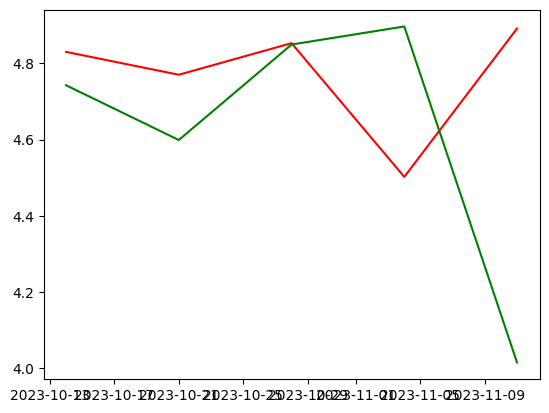

In [61]:
plt.plot(forecast_df['actuals'], 'r-', forecast_df['predictions'],'-g')

In [62]:
MAE = np.mean(abs(residuals))
print('Mean Absolute Error: ', MAE)

Mean Absolute Error:  0.3064313261195057


In [63]:
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error:  0.4379633372369467


In [64]:
print('Mean Absolute Percent Error: ' , round(np.mean(abs(residuals/test)),4))

Mean Absolute Percent Error:  0.0643


In [65]:
future_weeks = 10

In [66]:
total_period= pd.date_range(min(us_data.index), periods = len(us_data)+future_weeks, freq = 'W')

In [67]:
train_length = len(train)
horizon = len(total_period) -  len(train)
window = 1

lt_predictions = rolling_forecast(model_data, train_length, horizon, window)

In [68]:
lt_pred= pd.Series(lt_predictions, index=total_period[-(horizon):])

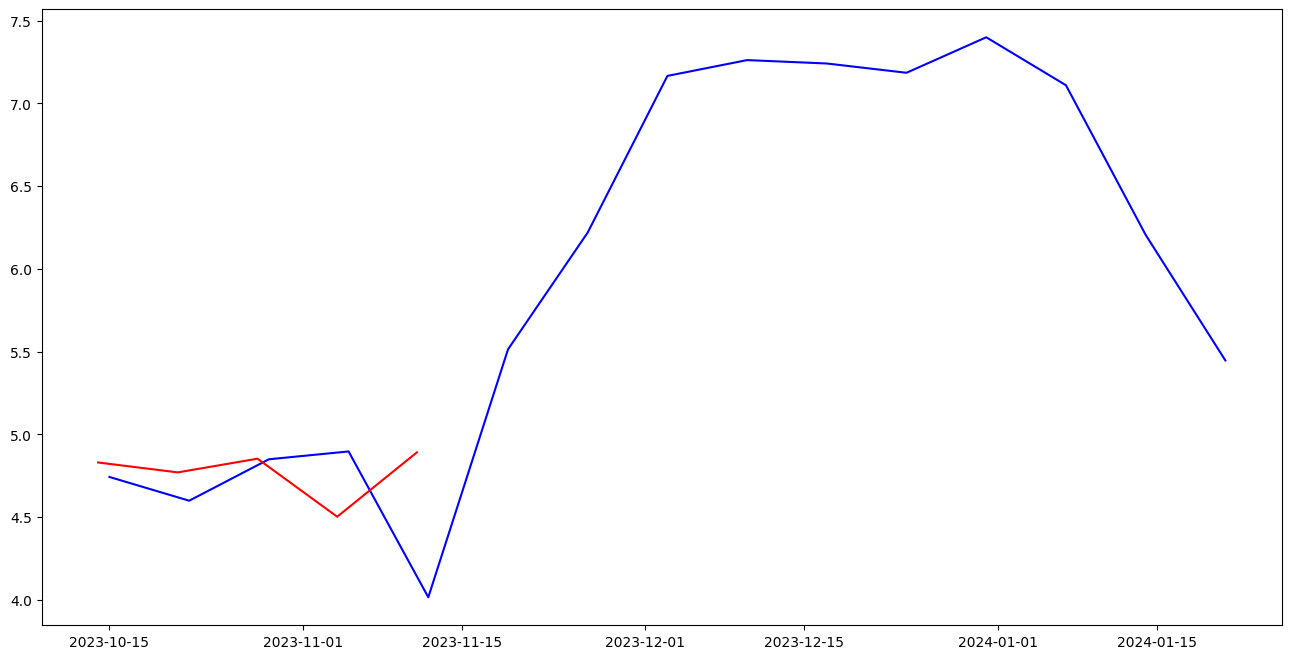

In [69]:
plt.figure(figsize=(16,8))
plt.plot(lt_pred, 'b-')
plt.plot(forecast_df['actuals'], '-r')

In [70]:
cases_per100k= np.max(lt_pred)*18.2*14

print('Peak Covid cases per 100k: ',cases_per100k)

n=5
prob_no_covid=(1-cases_per100k/100000)**n
print('Probability of visiting ',n,' people and not being exposed to covid: ',prob_no_covid)

Peak Covid cases per 100k:  1885.2177433909123
Probability of visiting  5  people and not being exposed to covid:  0.9092267864466442
